In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Input 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import os.path
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import csv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#TODO fix saliency https://github.com/raghakot/keras-vis/issues/228
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations
import scipy.ndimage as ndimage

warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

#hooking up GPU
physical_dev = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs avail: ", len(physical_dev))
tf.config.experimental.set_memory_growth(physical_dev[0], True)
#tf.debugging.set_log_device_placement(True)



os.chdir('C:/venv/tensorflow-scripting/data/lung-scans')

CURR_DIR = os.getcwd()

'''
#Grayscale 
if os.path.isdir('train_images_grays') is False:
    os.makedirs('train_images_grays')
    with open('labels/labels_train.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            img = Image.open(CURR_DIR + '/train_images/' + row['file_name'])
            img2 = img.convert('L') 
            img2.save(CURR_DIR + '/train_images_grays/' + row['file_name'])
'''   



#Data org
if os.path.isdir('train/healthy') is False:
    os.makedirs('train/healthy')
    os.makedirs('train/bacterial')
    os.makedirs('train/viral')
    os.makedirs('valid/healthy')
    os.makedirs('valid/bacterial')
    os.makedirs('valid/viral')
    os.makedirs('test/healthy')
    os.makedirs('test/bacterial')
    os.makedirs('test/viral')



    '''
    class_id = 0 if the image corresponds to a subject without disease (normal)  1227
    
    class_id = 1 if the image corresponds to a patient with bacterial pneumonia  2238

    class_id = 2 if the image corresponds to a patient with viral pneumonia      1207
    


    '''
    
    #purely cause I don't won't to rename it if I use greyscale folder
    train_images_folder = '/train_images/'
    
    #looking through the doc of labels and copying images to respetictive folders
    with open('labels/labels_train.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        class_id_0 = 0
        class_id_1 = 0
        class_id_2 = 0
        for row in reader:
#HEALTHY
            if(row['class_id'] == '0'):
                class_id_0+=1
                if(len([name for name in os.listdir(CURR_DIR + '/train/healthy/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/train/healthy/', name))]) < 1077):
                    file = train_images_folder + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/train/healthy/')
                elif(len([name for name in os.listdir(CURR_DIR + '/valid/healthy/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/valid/healthy/', name))]) < 100):
                    file = train_images_folder + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/valid/healthy/')
                elif(len([name for name in os.listdir(CURR_DIR + '/test/healthy/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/test/healthy/', name))]) < 50):
                    file = train_images_folder + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/test/healthy/')
                    
#BACTERIAL
            if(row['class_id'] == '1'):
                if(len([name for name in os.listdir(CURR_DIR + '/train/bacterial/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/train/bacterial/', name))]) < 2088):
                    file = train_images_folder + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/train/bacterial/')
                elif(len([name for name in os.listdir(CURR_DIR + '/valid/bacterial/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/valid/bacterial/', name))]) < 100):
                    file = train_images_folder + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/valid/bacterial/')
                elif(len([name for name in os.listdir(CURR_DIR + '/test/bacterial/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/test/bacterial/', name))]) < 50):
                    file = train_images_folder + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/test/bacterial/')
                    
#VIRAL                        
            if(row['class_id'] == '2'):
                if(len([name for name in os.listdir(CURR_DIR + '/train/viral/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/train/viral/', name))]) < 1057):
                    file = train_images_folder + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/train/viral/')
                elif(len([name for name in os.listdir(CURR_DIR + '/valid/viral/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/valid/viral/', name))]) < 100):
                    file = train_images_folder + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/valid/viral/')
                elif(len([name for name in os.listdir(CURR_DIR + '/test/viral/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/test/viral/', name))]) < 50):
                    file = train_images_folder + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/test/viral/')
                    

os.chdir('../../')
print('finished organising data')

Num GPUs avail:  1
finished organising data


In [23]:
train_path = 'data/lung-scans/train'
valid_path = 'data/lung-scans/valid'
test_path = 'data/lung-scans/test'

# then use this function as the preprocessing function in the generator
def grey_preprocessor (xarray):
    xarray=(xarray/127.5)-1
    return xarray


train_batches = ImageDataGenerator(preprocessing_function = grey_preprocessor).flow_from_directory(
    directory = train_path, target_size=(224,224), classes = ['bacterial', 'healthy', 'viral'], batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = grey_preprocessor).flow_from_directory(
    directory = valid_path, target_size=(224,224), classes = ['bacterial', 'healthy', 'viral'], batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = grey_preprocessor).flow_from_directory(
    directory = test_path, target_size=(224,224), classes = ['bacterial', 'healthy', 'viral'], batch_size = 10, shuffle = False)

assert train_batches.n == 4222
assert valid_batches.n == 300
assert test_batches.n == 150
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

#plotImages(imgs)
#print(labels)

Found 4222 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


In [45]:
#BUILDING VGG16
vgg16_model = tf.keras.applications.vgg16.VGG16()

#vgg16_model.summary()
#Loop through every except last vgg16 classifies 1000 classes.( we need only 3) and add them to the new model
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    
#model.summary()

#for layer in model.layers:
#    layer.trainable = False

#Adding final classifier
model.add(Dense(units = 3, activation = 'softmax'))

model.summary()

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [24]:
history = model.fit(x = train_batches, validation_data = valid_batches, epochs = 9, verbose = 2)

In [ ]:
#GOOGLENET
import keras
import keras.layers.core# import Layer
import keras.backend as K
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,  \
    Dropout, Dense, Input, concatenate,      \
    GlobalAveragePooling2D, AveragePooling2D,\
    Flatten

import cv2 
import numpy as np 
from keras.datasets import cifar10 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler

#TODO PREPROC DATA FOR GNET
num_classes = 3

def load_gnet_data(img_rows, img_cols):

    # Load cifar10 training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()

    # Resize training images
    X_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_train[:,:,:,:]])
    X_valid = np.array([cv2.resize(img, (img_rows,img_cols)) for img in X_valid[:,:,:,:]])

    # Transform targets to keras compatible format
    Y_train = np_utils.to_categorical(Y_train, num_classes)
    Y_valid = np_utils.to_categorical(Y_valid, num_classes)
    
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')

    # preprocess data
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return X_train, Y_train, X_valid, Y_valid
X_train, y_train, X_test, y_test = load_cifar10_data(224, 224)

In [50]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
#1 param was 10
x1 = Dense(3, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
#first param was 10
x2 = Dense(3, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(3, activation='softmax', name='output')(x)

gnet_model = Model(input_layer, [x, x1, x2], name='inception_v1')
#gnet_model.summary()

epochs = 10
initial_lrate = 0.01

def decay(epoch, steps=100):
    initial_lrate = 0.01
    drop = 0.96
    epochs_drop = 8
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

sgd = SGD(lr=initial_lrate, momentum=0.9, nesterov=False)

lr_sc = LearningRateScheduler(decay, verbose=1)

gnet_model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'], loss_weights=[1, 0.3, 0.3], optimizer=sgd, metrics=['accuracy'])

In [51]:
history = gnet_model.fit(x = train_batches, validation_data = valid_batches, epochs=epochs, batch_size=256, callbacks=[lr_sc])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
Epoch 1/10
423/423 [==============================] - 78s 185ms/step - loss: 1.7611 - output_loss: 1.1246 - auxilliary_output_1_loss: 1.0587 - auxilliary_output_2_loss: 1.0629 - output_accuracy: 0.4576 - auxilliary_output_1_accuracy: 0.4808 - auxilliary_output_2_accuracy: 0.4780 - val_loss: 1.9729 - val_output_loss: 1.2858 - val_auxilliary_output_1_loss: 1.1105 - val_auxilliary_output_2_loss: 1.1799 - val_output_accuracy: 0.3333 - val_auxilliary_output_1_accuracy: 0.3333 - val_auxilliary_output_2_accuracy: 0.3333

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
Epoch 2/10
423/423 [==============================] - 71s 169ms/step - loss: 1.6807 - output_loss: 1.0536 - auxilliary_output_1_loss: 1.0440 - auxilliary_output_2_loss: 1.0462 - output_accuracy: 0.4943 - auxilliary_output_1_accuracy: 0.4946 - auxilliary_output_2_accuracy: 0.4946 - val_loss: 1.8407 - val_output_loss: 1.1461 - val_auxilliary_out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

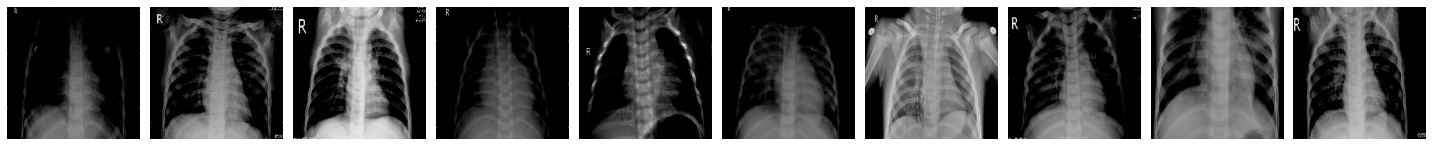

In [63]:
#PREDICTING
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
#predictions = model.predict(x=test_batches, verbose = 0)
predictions = gnet_model.predict(x=test_batches, verbose = 0)
test_batches.classes
#print(predictions)
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions[2], axis = -1))
test_batches.class_indices

cm_plot_labels = ['bacterial', 'healthy', 'viral']

In [26]:
#TODO visualization
"""
# visualize feature maps output from each block in the vgg model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import matplotlib.pyplot as plt
from numpy import expand_dims


# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model_vis = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
# convert the image to an array
#img = load_img(f'../input/test_images/270a532df702.png', target_size=(224, 224))
# convert the image to an array
img = img_to_array(imgs[0])
plt.imshow(img)
# expand dimensions so that it represents a single 'sample'
#img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
#img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		plt.figure(figsize=(64,64))
		for _ in range(square):
           

			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			
			# plot filter channel in grayscale
			plt.imshow(fmap[0, :, :, ix-1], cmap='viridis')
			ix += 1
	# show the figure

        
	plt.show()
"""

Confusion matrix, without norm
[[40  1  9]
 [ 0 50  0]
 [19  8 23]]


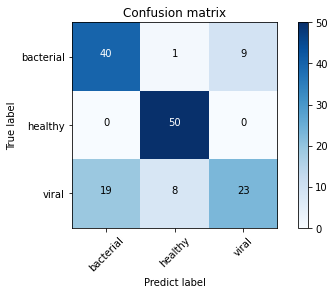

In [64]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Cunfusion matrix',
                          cmap = plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize  = True'.
    """
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without norm")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
            horizontalalignment = "center",
            color = "white" if cm[i,j] > thresh else "black")
            
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion matrix')

In [46]:
for layer in vgg16_model.layers[:-1]:
    print(layer)
    print(layer.get_config())
vgg16_model.summary()

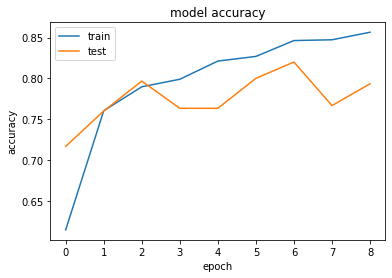

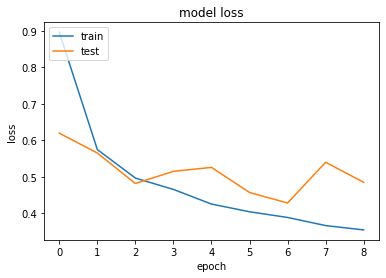

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()